# pip & import

In [12]:
!pip install autogluon

In [13]:
!pip install micropip

In [14]:
!pip install matplotlib-venn

In [15]:
#hiddencell
import micropip
await micropip.install("seaborn")

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

fe = fm.FontEntry(fname = 'MaruBuri-Regular.otf', name = 'MaruBuri')
fm.fontManager.ttflist.insert(0, fe)
plt.rc('font', family='MaruBuri')

In [16]:
from autogluon.core.metrics import get_metric
from autogluon.tabular import TabularDataset, TabularPredictor
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor

In [17]:
import os
import random
import numpy as np
import pandas as pd

In [18]:
!rm -rf ~/.cache/matplotlib

In [19]:
!sudo apt-get install fonts-nanum

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 10 not upgraded.


In [20]:
!sudo fc-cache -fv

/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/nanum: skipping, looped directory detected
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent cache directory
/root/.fontconfig: not cleaning non-existent cache director

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import font_manager as fm
plt.rc('font', family='NanumBarunGothic')
sns.set(font="NanumBarunGothic",
        rc={"axes.unicode_minus":False},
        style='darkgrid')
plt.rcParams['font.family'] = 'NanumBarunGothic'

In [22]:
plt.rc('font', family='NanumBarunGothic')
# 한글 폰트 사용 시 마이너스 폰트 깨짐 방지
plt.rc('axes', unicode_minus=False)

# **대구 교통 사고 피해 예측 AI 경진대회**

## seed 고정 & 함수 정의


In [23]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(42)

## **데이터 불러오기 및 상위행 확인**  

train.csv, test.csv 파일을 로드하여 상위행을 출력해 봅시다

In [24]:
# 구글 드라이브 연결
from google.colab import drive
drive.mount("/content/data")

Mounted at /content/data


In [25]:
# 딕셔너리를 간편하게 사용하는 것을 도와준다. 모델 class 처럼 사용 가능
# dot을 이용해 객체를 불러 사용. JSON 다룰때 유용.
import easydict
args = easydict.EasyDict()

# path
args.default_path = "/content/data/MyDrive/Playdata/Competitions/ML/DG/Data/" # 메인 경로
args.train_path = args.default_path + "train.csv" # train 데이터 경로
args.test_path = args.default_path + "test.csv" # train 데이터 경로

args.default_submission_path = args.default_path + "sample_submission.csv" # 예측결과(제출파일) 경로
args.result_path = "/content/data/MyDrive/Playdata/Competitions/ML/DG/Result/submission_20231121.csv"

# 데이터 분석을 위한 변수들
# # 난수 생성 제어 => 같은 코드를 실행해도 동일한 결과를 얻기 위해서 설정
# 데이터 분할 및 모델 초기화 때 유용.
args.random_state = 42
args.results = [] # 결과 저장 리스트

In [27]:
train_org = pd.read_csv(args.train_path)
test_org = pd.read_csv(args.test_path)

In [29]:
train_df = train_org.copy()
test_df = test_org.copy()

In [30]:
train_df['시'] = train_df['시군구'].apply(lambda x: x.split()[0] if len(x.split()) > 0 else '')
train_df['군'] = train_df['시군구'].apply(lambda x: x.split()[1] if len(x.split()) > 1 else '')
train_df['구'] = train_df['시군구'].apply(lambda x: x.split()[2] if len(x.split()) > 2 else '')

## EDA

In [31]:
train_eda = train_org.copy()

In [32]:
train_eda.columns

Index(['ID', '사고일시', '요일', '기상상태', '시군구', '도로형태', '노면상태', '사고유형',
       '사고유형 - 세부분류', '법규위반', '가해운전자 차종', '가해운전자 성별', '가해운전자 연령', '가해운전자 상해정도',
       '피해운전자 차종', '피해운전자 성별', '피해운전자 연령', '피해운전자 상해정도', '사망자수', '중상자수',
       '경상자수', '부상자수', 'ECLO'],
      dtype='object')

In [33]:
train_eda['기상상태'].value_counts()

맑음    36181
비      2627
흐림      729
기타       56
안개        8
눈         8
Name: 기상상태, dtype: int64

In [34]:
train_eda['가해운전자 차종'].value_counts()

승용             26705
이륜              4091
화물              4040
승합              1376
자전거             1234
기타불명             978
원동기              462
건설기계             425
개인형이동수단(PM)      172
특수               113
사륜오토바이(ATV)       10
농기계                3
Name: 가해운전자 차종, dtype: int64

In [35]:
train_eda['법규위반'].value_counts()

안전운전불이행      21876
안전거리미확보       5277
신호위반          3786
교차로운행방법위반     2750
기타            1396
보행자보호의무위반     1154
직진우회전진행방해      980
차로위반           949
중앙선침범          881
불법유턴           427
과속             133
Name: 법규위반, dtype: int64

In [36]:
train_eda.isnull().sum()

ID               0
사고일시             0
요일               0
기상상태             0
시군구              0
도로형태             0
노면상태             0
사고유형             0
사고유형 - 세부분류      0
법규위반             0
가해운전자 차종         0
가해운전자 성별         0
가해운전자 연령         0
가해운전자 상해정도       0
피해운전자 차종       991
피해운전자 성별       991
피해운전자 연령       991
피해운전자 상해정도     991
사망자수             0
중상자수             0
경상자수             0
부상자수             0
ECLO             0
dtype: int64

In [ ]:
train_eda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39609 entries, 0 to 39608
Data columns (total 23 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ID           39609 non-null  object
 1   사고일시         39609 non-null  object
 2   요일           39609 non-null  object
 3   기상상태         39609 non-null  object
 4   시군구          39609 non-null  object
 5   도로형태         39609 non-null  object
 6   노면상태         39609 non-null  object
 7   사고유형         39609 non-null  object
 8   사고유형 - 세부분류  39609 non-null  object
 9   법규위반         39609 non-null  object
 10  가해운전자 차종     39609 non-null  object
 11  가해운전자 성별     39609 non-null  object
 12  가해운전자 연령     39609 non-null  object
 13  가해운전자 상해정도   39609 non-null  object
 14  피해운전자 차종     38618 non-null  object
 15  피해운전자 성별     38618 non-null  object
 16  피해운전자 연령     38618 non-null  object
 17  피해운전자 상해정도   38618 non-null  object
 18  사망자수         39609 non-null  int64 
 19  중상자수         39609 non-nu

In [ ]:
train_eda['법규위반']

0          안전운전불이행
1               기타
2          안전운전불이행
3          안전운전불이행
4          안전운전불이행
           ...    
39604         신호위반
39605      안전거리미확보
39606    교차로운행방법위반
39607      안전운전불이행
39608      안전운전불이행
Name: 법규위반, Length: 39609, dtype: object

In [37]:
from sklearn.preprocessing import LabelEncoder

In [38]:
label_encoder = LabelEncoder()

In [39]:
train_eda['법규위반'].unique()

array(['안전운전불이행', '기타', '교차로운행방법위반', '신호위반', '중앙선침범', '안전거리미확보', '차로위반',
       '보행자보호의무위반', '직진우회전진행방해', '과속', '불법유턴'], dtype=object)

In [40]:
train_eda['법규위반_숫자'] = label_encoder.fit_transform(train_eda['법규위반'])
train_eda['기상상태_숫자'] = label_encoder.fit_transform(train_eda['기상상태'])
train_eda['도로형태_숫자'] = label_encoder.fit_transform(train_eda['도로형태'])
train_eda['노면상태_숫자'] = label_encoder.fit_transform(train_eda['노면상태'])
train_eda['사고유형_숫자'] = label_encoder.fit_transform(train_eda['사고유형'])
train_eda['사고유형 - 세부분류_숫자'] = label_encoder.fit_transform(train_eda['사고유형 - 세부분류'])
train_eda['가해운전자 차종_숫자'] = label_encoder.fit_transform(train_eda['가해운전자 차종'])
train_eda['피해운전자 차종_숫자'] = label_encoder.fit_transform(train_eda['피해운전자 차종'])
train_eda['가해운전자 상해정도_숫자'] = label_encoder.fit_transform(train_eda['가해운전자 상해정도'])
train_eda['피해운전자 상해정도_숫자'] = label_encoder.fit_transform(train_eda['피해운전자 상해정도'])


In [41]:
train_eda_number = train_eda.select_dtypes(include=np.number)
train_eda_tmp = train_eda_number
train_eda_number.columns

Index(['사망자수', '중상자수', '경상자수', '부상자수', 'ECLO', '법규위반_숫자', '기상상태_숫자', '도로형태_숫자',
       '노면상태_숫자', '사고유형_숫자', '사고유형 - 세부분류_숫자', '가해운전자 차종_숫자', '피해운전자 차종_숫자',
       '가해운전자 상해정도_숫자', '피해운전자 상해정도_숫자'],
      dtype='object')

/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 49324 (\N{HANGUL SYLLABLE SA}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 47581 (\N{HANGUL SYLLABLE MANG}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 51088 (\N{HANGUL SYLLABLE JA}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 51473 (\N{HANGUL SYLLABLE JUNG}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.10/dist-packages/seabor

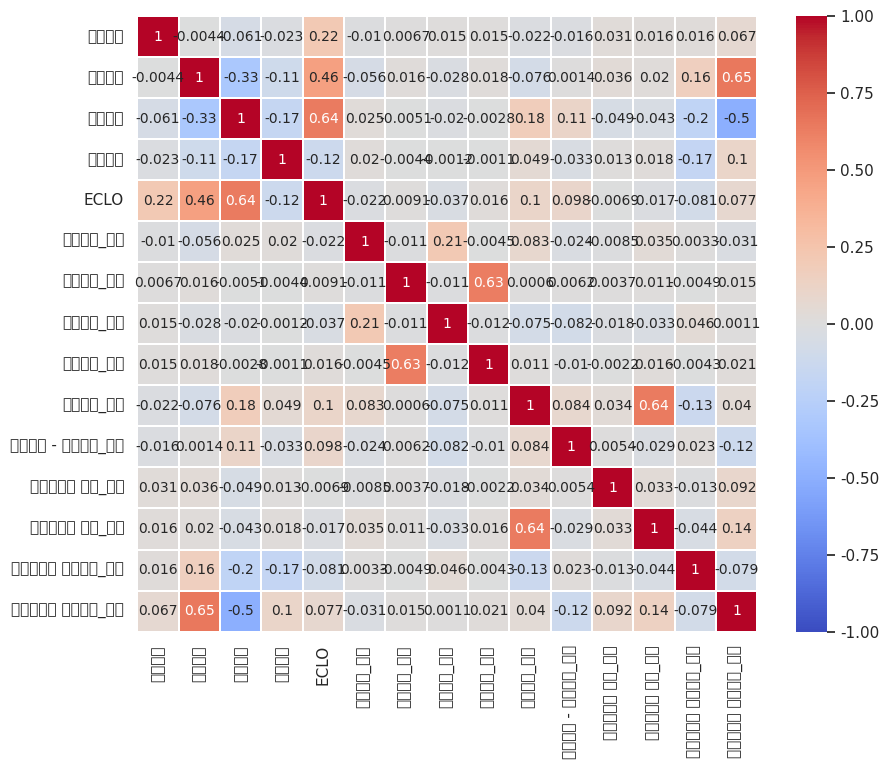

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns

# 나눔 바른고딕 폰트 설정
sns.set(font="NanumBarunGothic")

# 그래프의 기본 폰트 설정
plt.rcParams["font.family"] = 'NanumBarunGothic'

# 히트맵 생성 코드
plt.figure(figsize=(10, 8))
heatmap = sns.heatmap(train_eda_tmp.corr(), vmin=-1, vmax=1, annot=True, linewidths=0.2, cmap='coolwarm')

# 각 셀의 텍스트에 대한 폰트 설정
for text in heatmap.texts:
    text.set_fontsize(10)  # 폰트 크기를 원하는 크기로 조절하세요

# 플롯 보여주기
plt.show()

### 범주형_EDA

In [43]:
train_eda_object = train_eda.select_dtypes(include='object')
train_eda_object.columns

Index(['ID', '사고일시', '요일', '기상상태', '시군구', '도로형태', '노면상태', '사고유형',
       '사고유형 - 세부분류', '법규위반', '가해운전자 차종', '가해운전자 성별', '가해운전자 연령', '가해운전자 상해정도',
       '피해운전자 차종', '피해운전자 성별', '피해운전자 연령', '피해운전자 상해정도'],
      dtype='object')

In [44]:
train_eda_object

,ID,사고일시,요일,기상상태,시군구,도로형태,노면상태,사고유형,사고유형 - 세부분류,법규위반,가해운전자 차종,가해운전자 성별,가해운전자 연령,가해운전자 상해정도,피해운전자 차종,피해운전자 성별,피해운전자 연령,피해운전자 상해정도
0,ACCIDENT_00000,2019-01-01 00,화요일,맑음,대구광역시 중구 대신동,단일로 - 기타,건조,차대사람,길가장자리구역통행중,안전운전불이행,승용,여,51세,상해없음,보행자,여,70세,중상
1,ACCIDENT_00001,2019-01-01 00,화요일,흐림,대구광역시 달서구 감삼동,단일로 - 기타,건조,차대사람,보도통행중,기타,승용,남,39세,상해없음,보행자,남,61세,경상
2,ACCIDENT_00002,2019-01-01 01,화요일,맑음,대구광역시 수성구 두산동,단일로 - 기타,건조,차대사람,차도통행중,안전운전불이행,승용,남,70세,상해없음,보행자,남,38세,경상
3,ACCIDENT_00003,2019-01-01 02,화요일,맑음,대구광역시 북구 복현동,단일로 - 기타,건조,차대차,추돌,안전운전불이행,승용,남,49세,상해없음,승용,남,36세,중상
4,ACCIDENT_00004,2019-01-01 04,화요일,맑음,대구광역시 동구 신암동,단일로 - 기타,건조,차대차,추돌,안전운전불이행,승용,남,30세,상해없음,승용,남,52세,경상
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39604,ACCIDENT_39604,2021-12-31 19,금요일,맑음,대구광역시 수성구 수성동3가,교차로 - 교차로안,건조,차대차,측면충돌,신호위반,승용,여,52세,상해없음,이륜,남,28세,경상
39605,ACCIDENT_39605,2021-12-31 19,금요일,맑음,대구광역시 달서구 상인동,단일로 - 기타,건조,차대차,측면충돌,안전거리미확보,승용,여,60세,상해없음,승용,남,52세,경상
39606,ACCIDENT_39606,2021-12-31 21,금요일,맑음,대구광역시 달서구 월성동,교차로 - 교차로안,건조,차대차,측면충돌,교차로운행방법위반,승용,남,60세,중상,승용,남,73세,중상
39607,ACCIDENT_39607,2021-12-31 22,금요일,맑음,대구광역시 달서구 장동,기타 - 기타,건조,차대차,추돌,안전운전불이행,승용,남,40세,상해없음,승용,여,57세,경상


In [45]:
train_eda_object["기상상태"] = train_eda_object["기상상태"].astype("category")

In [46]:
train_eda_object.describe()

,ID,사고일시,요일,기상상태,시군구,도로형태,노면상태,사고유형,사고유형 - 세부분류,법규위반,가해운전자 차종,가해운전자 성별,가해운전자 연령,가해운전자 상해정도,피해운전자 차종,피해운전자 성별,피해운전자 연령,피해운전자 상해정도
count,39609,39609,39609,39609,39609,39609,39609,39609,39609,39609,39609,39609,39609,39609,38618,38618,38618,38618
unique,39609,18057,7,6,199,11,6,3,14,11,12,3,89,6,13,3,97,6
top,ACCIDENT_00000,2019-11-15 18,금요일,맑음,대구광역시 남구 대명동,단일로 - 기타,건조,차대차,측면충돌,안전운전불이행,승용,남,60세,상해없음,승용,남,59세,경상
freq,1,13,6179,36181,1749,19485,36420,31785,17104,21876,26705,29052,1031,29309,20315,27505,867,25034


In [ ]:
train_eda_object['가해운전자 상해정도'].nunique()

6

In [ ]:
train_eda_object['피해운전자 상해정도'].mode()

0    경상
Name: 피해운전자 상해정도, dtype: object

In [47]:
train_eda_object['가해운전자 상해정도'].mode()

0    상해없음
Name: 가해운전자 상해정도, dtype: object

In [48]:
train_eda_object["기상상태"]

0        맑음
1        흐림
2        맑음
3        맑음
4        맑음
         ..
39604    맑음
39605    맑음
39606    맑음
39607    맑음
39608    맑음
Name: 기상상태, Length: 39609, dtype: category
Categories (6, object): ['기타', '눈', '맑음', '비', '안개', '흐림']

## **train, test 데이터 기간 확인하기**  

학습(train) 데이터의 기간과 예측 대상이 되는 test 데이터의 기간을 살펴 봅니다

In [49]:
display(f"train : {train_org.iloc[0]['사고일시']} ~ {train_org.iloc[-1]['사고일시']}")
display(f"test : {test_org.iloc[0]['사고일시']} ~ {test_org.iloc[-1]['사고일시']}")

'train : 2019-01-01 00 ~ 2021-12-31 23'

'test : 2022-01-01 01 ~ 2022-12-31 21'

## **예측 대상 확인하기**

sample_submission.csv를 로드하여 출력 형식을 확인해 봄으로서,
대회 페이지 규칙에 기술되어 있는, 예측 대상이 무엇인지 확인해 봅시다.

최종적으로 예측해야 하는 값은 'ECLO'(인명피해 심각도) 값입니다.

그러나, train데이터 컬럼에 있는 '사망자수', '중상자수', '경상자수', '부상자수'를 각각 예측하여 ECLO 예측값을 구할 수도 있습니다. 즉, ECLO 값을 예측하는 단일 모델로 접근할 수도,  각각을 별도로 예측하는 모델로 접근할 수도 있습니다.

In [51]:
sample_submission = pd.read_csv(args.default_submission_path)
sample_submission.head()

,ID,ECLO
0,ACCIDENT_39609,0
1,ACCIDENT_39610,0
2,ACCIDENT_39611,0
3,ACCIDENT_39612,0
4,ACCIDENT_39613,0


## **데이터 전처리**  

현재 '사고일시', '시군구', '도로형태' 컬럼은 반복되는 패턴으로 여러 정보를 포함하고 있습니다
이런 반복되는 패턴을 일반화하면 pandas에서 제공하는 str.extract를 통해 한 번에 추출 가능합니다  

## **파생 변수 생성 1 : 날짜, 시간정보 생성**

'사고일시' 컬럼으로 부터 연도, 월, 일, 시간 정보 추출 및 변환 합니다

In [52]:
time_pattern = r'(\d{4})-(\d{1,2})-(\d{1,2}) (\d{1,2})'

train_df[['연', '월', '일', '시간']] = train_org['사고일시'].str.extract(time_pattern)
train_df[['연', '월', '일', '시간']] = train_df[['연', '월', '일', '시간']].apply(pd.to_numeric) # 추출된 문자열을 수치화해줍니다
train_df = train_df.drop(columns=['사고일시']) # 정보 추출이 완료된 '사고일시' 컬럼은 제거합니다

# 해당 과정을 test_x에 대해서도 반복해줍니다
test_df[['연', '월', '일', '시간']] = test_org['사고일시'].str.extract(time_pattern)
test_df[['연', '월', '일', '시간']] = test_df[['연', '월', '일', '시간']].apply(pd.to_numeric)
test_df = test_df.drop(columns=['사고일시'])

display(f"columns of train_df : {train_df.columns}")
display(f"columns of test_df : {test_df.columns}")

"columns of train_df : Index(['ID', '요일', '기상상태', '시군구', '도로형태', '노면상태', '사고유형', '사고유형 - 세부분류',\n       '법규위반', '가해운전자 차종', '가해운전자 성별', '가해운전자 연령', '가해운전자 상해정도', '피해운전자 차종',\n       '피해운전자 성별', '피해운전자 연령', '피해운전자 상해정도', '사망자수', '중상자수', '경상자수', '부상자수',\n       'ECLO', '시', '군', '구', '연', '월', '일', '시간'],\n      dtype='object')"

"columns of test_df : Index(['ID', '요일', '기상상태', '시군구', '도로형태', '노면상태', '사고유형', '연', '월', '일', '시간'], dtype='object')"

## **파생 변수 생성 2 : 공간(위치) 정보 생성**

'시군구' 컬럼으로부터 의미 있는 공산 정보를 추출 및 변환 합니다

In [53]:
location_pattern = r'(\S+) (\S+) (\S+)'

train_df[['도시', '구', '동']] = train_org['시군구'].str.extract(location_pattern)
train_df = train_df.drop(columns=['시군구'])

test_df[['도시', '구', '동']] = test_org['시군구'].str.extract(location_pattern)
test_df = test_df.drop(columns=['시군구'])

display(f"columns of train_df : {train_df.columns}")
display(f"columns of test_df : {test_df.columns}")

"columns of train_df : Index(['ID', '요일', '기상상태', '도로형태', '노면상태', '사고유형', '사고유형 - 세부분류', '법규위반',\n       '가해운전자 차종', '가해운전자 성별', '가해운전자 연령', '가해운전자 상해정도', '피해운전자 차종',\n       '피해운전자 성별', '피해운전자 연령', '피해운전자 상해정도', '사망자수', '중상자수', '경상자수', '부상자수',\n       'ECLO', '시', '군', '구', '연', '월', '일', '시간', '도시', '동'],\n      dtype='object')"

"columns of test_df : Index(['ID', '요일', '기상상태', '도로형태', '노면상태', '사고유형', '연', '월', '일', '시간', '도시',\n       '구', '동'],\n      dtype='object')"

## **파생 변수 추출 3 : 도로 형태 정보 추출**  

'도로형태' 컬럼은 '단일로 - 기타'와 같은 패턴으로 구성되어 있습니다. 이를 두종류의 독립된 정보로 보고 두개의 컬럼으로 분리하여 생성합니다.

In [54]:
road_pattern = r'(.+) - (.+)'

train_df[['도로형태1', '도로형태2']] = train_org['도로형태'].str.extract(road_pattern)
train_df = train_df.drop(columns=['도로형태'])

test_df[['도로형태1', '도로형태2']] = test_org['도로형태'].str.extract(road_pattern)
test_df = test_df.drop(columns=['도로형태'])

display(f"columns of train_df : {train_df.columns}")
display(f"columns of test_df : {test_df.columns}")

"columns of train_df : Index(['ID', '요일', '기상상태', '노면상태', '사고유형', '사고유형 - 세부분류', '법규위반', '가해운전자 차종',\n       '가해운전자 성별', '가해운전자 연령', '가해운전자 상해정도', '피해운전자 차종', '피해운전자 성별',\n       '피해운전자 연령', '피해운전자 상해정도', '사망자수', '중상자수', '경상자수', '부상자수', 'ECLO', '시',\n       '군', '구', '연', '월', '일', '시간', '도시', '동', '도로형태1', '도로형태2'],\n      dtype='object')"

"columns of test_df : Index(['ID', '요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '도시', '구', '동',\n       '도로형태1', '도로형태2'],\n      dtype='object')"

## **전처리 결과 확인**

지금까지 전처리한 결과를 확인해 봅시다

In [55]:
train_df.columns

Index(['ID', '요일', '기상상태', '노면상태', '사고유형', '사고유형 - 세부분류', '법규위반', '가해운전자 차종',
       '가해운전자 성별', '가해운전자 연령', '가해운전자 상해정도', '피해운전자 차종', '피해운전자 성별',
       '피해운전자 연령', '피해운전자 상해정도', '사망자수', '중상자수', '경상자수', '부상자수', 'ECLO', '시',
       '군', '구', '연', '월', '일', '시간', '도시', '동', '도로형태1', '도로형태2'],
      dtype='object')

In [56]:
test_df.columns

Index(['ID', '요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '도시', '구', '동',
       '도로형태1', '도로형태2'],
      dtype='object')

## **train, test 데이터의 독립변수, 종속 변수 분리**

모델 추론 시점에서 획득할 수 있는 데이터는 학습 시점에서 활용할 수 있는 데이터와 다를 수 있습니다  
그렇기에 본 baseline에서는 test 시점에서만 활용할 수 있는 데이터들(test의 column들)만 사용하여 train 데이터를 구성했습니다

train_df 중에서 test_x가 가진 column들만 추출하여 train_x(독립변수)를 구성하고, train_df 중에서 예측 목표인 EPDO를 추출하여 train_y(종속변수)를 구성합니다

In [57]:
test_features = test_df.drop(columns=['ID']).copy()
train_features = train_df[test_features.columns].copy()
train_target = train_df['ECLO'].copy()

## **범주형(Categorical) 변수, 수치형 변수로 변환하기**

모델 학습을 위해 train_x의 문자열 타입의 컬럼들을 추출하고, LabelEncoder를 활용하여 이 컬럼들을 모두 수치형 변수로 변환해 보겠습니다

In [58]:
from sklearn.preprocessing import LabelEncoder

categorical_features = list(train_features.dtypes[train_features.dtypes == "object"].index)
# 추출된 문자열 변수 확인
display(categorical_features)

for i in categorical_features:
    le = LabelEncoder()
    le=le.fit(train_features[i])
    train_features[i]=le.transform(train_features[i])

    for case in np.unique(test_features[i]):
        if case not in le.classes_:
            le.classes_ = np.append(le.classes_, case)
    test_features[i]=le.transform(test_features[i])

display(train_features.head())
display(test_features.head())

['요일', '기상상태', '노면상태', '사고유형', '도시', '구', '동', '도로형태1', '도로형태2']

,요일,기상상태,노면상태,사고유형,연,월,일,시간,도시,구,동,도로형태1,도로형태2
0,6,2,0,0,2019,1,1,0,0,7,40,2,5
1,6,5,0,0,2019,1,1,0,0,1,4,2,5
2,6,2,0,0,2019,1,1,1,0,6,66,2,5
3,6,2,0,1,2019,1,1,2,0,4,79,2,5
4,6,2,0,1,2019,1,1,4,0,3,129,2,5


,요일,기상상태,노면상태,사고유형,연,월,일,시간,도시,구,동,도로형태1,도로형태2
0,5,2,0,0,2022,1,1,1,0,6,99,0,3
1,5,2,0,0,2022,1,1,1,0,6,168,2,5
2,5,2,0,1,2022,1,1,4,0,6,117,0,3
3,5,2,0,1,2022,1,1,4,0,6,126,2,5
4,5,2,0,1,2022,1,1,6,0,1,4,0,3


## **Model Train & Prediction**

전체 학습 데이터에 대하여 학습후 최종 예측을 합니다. 여기서는 DecisionTreeRegressor 모델로 학습하고 예측하는 예시 코드입니다.

## K-Fold

In [59]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn import svm
from sklearn import datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import RandomizedSearchCV

In [60]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.model_selection import StratifiedKFold

In [61]:
# 교차 검증
skf = StratifiedKFold(n_splits=6, shuffle=True, random_state=0)

## DecisionTreeRegressor

In [62]:
model = DecisionTreeRegressor(random_state=42)

n_iter = 0
rmse_lst = []

for train_index, valid_index in skf.split(train_features, train_target):
    n_iter += 1
    # 학습용, 검증용 데이터 구성
    train_x, valid_x = train_features.iloc[train_index], train_features.iloc[valid_index]
    train_y, valid_y = train_target.iloc[train_index], train_target.iloc[valid_index]

    # 학습
    model.fit(train_x, train_y)

    valid_pred = model.predict(valid_x)  # 예측값

    # 평가
    rmse = mean_squared_error(valid_y, valid_pred, squared=False)
    rmse_lst.append(rmse)
    print(f'{n_iter} 번째 Stratified Stratified K-Fold RMSE: {rmse}')

# 최종 평가
print('-'*50)
print(f'교차 검증 RMSE: {np.mean(rmse_lst)}')

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=6.
  warnings.warn(


1 번째 Stratified Stratified K-Fold RMSE: 4.700528823530622
2 번째 Stratified Stratified K-Fold RMSE: 4.81882840950269
3 번째 Stratified Stratified K-Fold RMSE: 4.710274498664795
4 번째 Stratified Stratified K-Fold RMSE: 4.873303914882704
5 번째 Stratified Stratified K-Fold RMSE: 4.748224618180276
6 번째 Stratified Stratified K-Fold RMSE: 4.711631685923653
--------------------------------------------------
교차 검증 RMSE: 4.760465325114123


## DecisionTreeClassifier

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_squared_error

In [ ]:
model = DecisionTreeClassifier(random_state=42)

n_iter = 0
rmse_lst = []

for train_index, valid_index in skf.split(train_features, train_target):
    n_iter += 1
    # 학습용, 검증용 데이터 구성
    train_x, valid_x = train_features.iloc[train_index], train_features.iloc[valid_index]
    train_y, valid_y = train_target.iloc[train_index], train_target.iloc[valid_index]

    # 학습
    model.fit(train_x, train_y)

    valid_pred = model.predict(valid_x)  # 예측값
    print(valid_pred)

    # 평가
    rmse = mean_squared_error(valid_y, valid_pred, squared=False)
    rmse_lst.append(rmse)
    print(f'{n_iter} 번째 Stratified Stratified K-Fold RMSE: {rmse}')

# 최종 평가
print('-'*50)
print(f'교차 검증 RMSE: {np.mean(rmse_lst)}')

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=6.
  warnings.warn(


[5 3 6 ... 3 9 3]
1 번째 Stratified Stratified K-Fold RMSE: 4.670594198452289
[3 3 3 ... 6 3 6]
2 번째 Stratified Stratified K-Fold RMSE: 4.835431684543387
[3 5 6 ... 6 5 3]
3 번째 Stratified Stratified K-Fold RMSE: 4.60800575687984
[5 5 5 ... 3 6 3]
4 번째 Stratified Stratified K-Fold RMSE: 4.6394140799895425
[ 8  3  5 ...  3  3 10]
5 번째 Stratified Stratified K-Fold RMSE: 4.515153163479992
[ 5 12  5 ...  3  3  3]
6 번째 Stratified Stratified K-Fold RMSE: 4.630131254840946
--------------------------------------------------
교차 검증 RMSE: 4.649788356364333


## XGBoost

### model 1

In [ ]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

In [ ]:
hp = {
    "random_state" : 42
}

model = XGBRegressor(**hp)
n_iter = 0
rmse_lst = []

for train_index, valid_index in skf.split(train_features, train_target):
  n_iter += 1
  # 학습용, 검증용 데이터 구성
  train_x, valid_x = train_features.iloc[train_index], train_features.iloc[valid_index]
  train_y, valid_y = train_target.iloc[train_index], train_target.iloc[valid_index]

  # 학습
  model.fit(train_x, train_y)
  valid_pred = model.predict(valid_x) # 예측값

  # 평가
  rmse = mean_squared_error(valid_y, valid_pred, squared=False)
  rmse_lst.append(rmse)
  print(f'{n_iter} 번째 Stratified K-Fold RMSE: {rmse}')

# 최종 평가
print('-'*50)
print(f'교차 검증 RMSE: {np.mean(rmse_lst)}')

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=6.
  warnings.warn(


1 번째 Stratified K-Fold RMSE: 3.2357949688735506
2 번째 Stratified K-Fold RMSE: 3.2099601010747563
3 번째 Stratified K-Fold RMSE: 3.2351619962167737
4 번째 Stratified K-Fold RMSE: 3.2109062638913204
5 번째 Stratified K-Fold RMSE: 3.284783641590352
6 번째 Stratified K-Fold RMSE: 3.27377898569952
--------------------------------------------------
교차 검증 RMSE: 3.241730992891045


### model 2

In [ ]:
hp = {
    "random_state" : 42,
    "verbose": 0, # 로그
}
model = XGBRegressor(**hp)

In [ ]:
n_iter=1 # 몇번 hp조합을 찾을 것인가?
scoring = 'neg_root_mean_squared_error' # 어떤 평가지표를 사용할 것인가?
hp={
    "max_depth" : np.linspace(5,12,8,dtype = int), # 깊이
    "n_estimators" : np.linspace(800,1200,200, dtype = int), # 부스팅 단계수
    "learning_rate" : np.logspace(-3, -1, 3)
}

# HPO 인스턴스 생성
rs1=RandomizedSearchCV(model, hp, scoring=scoring, n_iter=n_iter, n_jobs=-1, cv=skf, verbose=False)
# 학습 (best hp 조합 찾기)
rs1.fit(train_x, train_y)

# 학습 결과 (best hp 조합일 때,)
rs1.best_score_

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=6.
  warnings.warn(


[10:19:08] WARNING: ../src/learner.cc:767: 
Parameters: { "verbose" } are not used.



-3.6000782079907907

In [ ]:
best_params = rs1.best_params_
best_params

{'n_estimators': 920, 'max_depth': 9, 'learning_rate': 0.001}

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object)

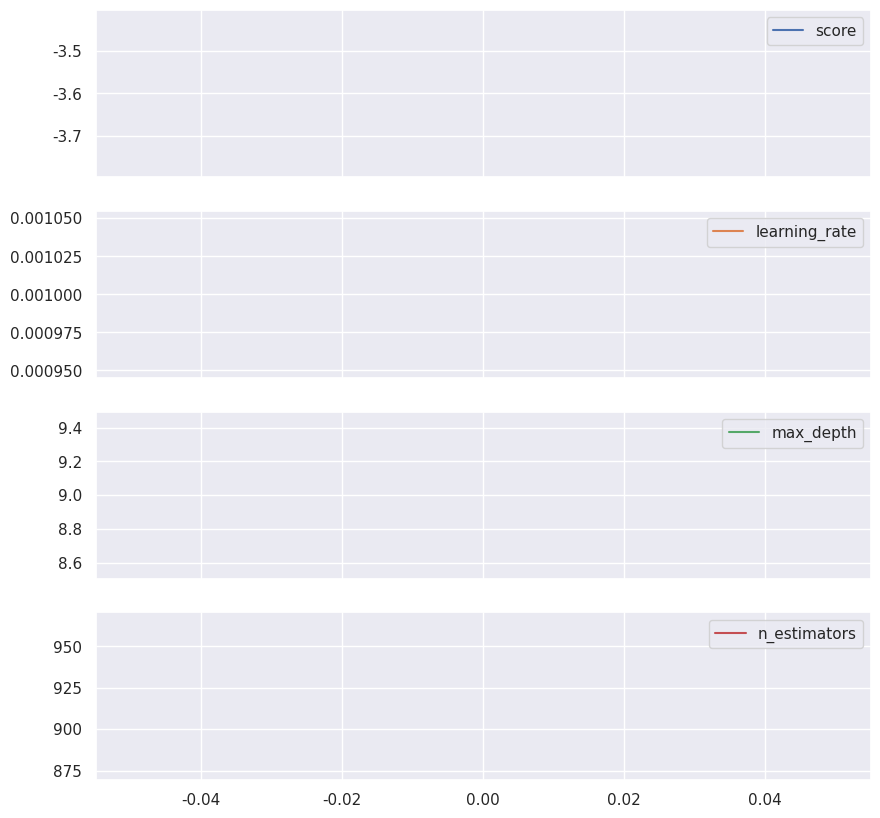

In [ ]:
rs_results_df=pd.DataFrame(np.transpose([rs1.cv_results_['mean_test_score'],
                                         rs1.cv_results_['param_learning_rate'].data,
                                         rs1.cv_results_['param_max_depth'].data,
                                         rs1.cv_results_['param_n_estimators'].data]),
                           columns=['score', 'learning_rate', 'max_depth', 'n_estimators'])
rs_results_df.plot(subplots=True,figsize=(10, 10))

In [ ]:
best_params['random_state'] = 42
best_params['verbose'] = 0

# best 모델 인스턴스 생성(정의)
best_mode = XGBRegressor(**hp)

In [ ]:
seed_everything(42)
n_iter = 0
rmse_lst = []

for train_index, valid_index in skf.split(train_features, train_target):
  n_iter += 1
  # 학습용, 검증용 데이터 구성
  train_x, valid_x = train_features.iloc[train_index], train_features.iloc[valid_index]
  train_y, valid_y = train_target.iloc[train_index], train_target.iloc[valid_index]

  # 학습
  model.fit(train_x, train_y)
  valid_pred = model.predict(valid_x) # 예측값

  # 평가
  rmse = mean_squared_error(valid_y, valid_pred, squared=False)
  rmse_lst.append(rmse)
  print(f'{n_iter} 번째 Stratified K-Fold RMSE: {rmse}')

# 최종 평가
print('-'*50)
print(f'교차 검증 RMSE: {np.mean(rmse_lst)}')

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=6.
  warnings.warn(


[10:20:14] WARNING: ../src/learner.cc:767: 
Parameters: { "verbose" } are not used.

1 번째 Stratified K-Fold RMSE: 3.2357949688735506
[10:20:18] WARNING: ../src/learner.cc:767: 
Parameters: { "verbose" } are not used.

2 번째 Stratified K-Fold RMSE: 3.2099601010747563
[10:20:21] WARNING: ../src/learner.cc:767: 
Parameters: { "verbose" } are not used.

3 번째 Stratified K-Fold RMSE: 3.2351619962167737
[10:20:24] WARNING: ../src/learner.cc:767: 
Parameters: { "verbose" } are not used.

4 번째 Stratified K-Fold RMSE: 3.2109062638913204
[10:20:27] WARNING: ../src/learner.cc:767: 
Parameters: { "verbose" } are not used.

5 번째 Stratified K-Fold RMSE: 3.284783641590352
[10:20:31] WARNING: ../src/learner.cc:767: 
Parameters: { "verbose" } are not used.

6 번째 Stratified K-Fold RMSE: 3.27377898569952
--------------------------------------------------
교차 검증 RMSE: 3.241730992891045


## Light GBM

### model 0

In [ ]:
from lightgbm import LGBMRegressor, plot_importance
from sklearn.metrics import mean_squared_error

In [ ]:
seed_everything(42)
hp= {
    'objective': 'regression',
    'boosting_type': 'gbdt',
    'metric': 'rmse',  # 회귀 모델의 성능 측정 메트릭 (Root Mean Squared Error)
    'num_leaves': 31,
    'learning_rate': 0.05,
    'verbose' : -1
}
model = LGBMRegressor(**hp)
n_iter = 0
accuracy_lst = []
rmse_lst = []
for train_index, valid_index in skf.split(train_features, train_target):
  n_iter += 1
  # 학습용, 검증용 데이터 구성
  tr_x, valid_x = train_features.iloc[train_index], train_features.iloc[valid_index]
  tr_y, valid_y = train_target.iloc[train_index], train_target.iloc[valid_index]

  # 학습
  model.fit(tr_x, tr_y)
  valid_pred = model.predict(valid_x) # 예측값

  # 평가
  rmse = mean_squared_error(valid_y, valid_pred, squared=False)
  rmse_lst.append(rmse)
  print(f'{n_iter} 번째 Stratified K-Fold RMSE: {rmse}')

# 최종 평가
print('-'*50)
print(f'교차 검증 RMSE: {np.mean(rmse_lst)}')

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=6.
  warnings.warn(


1 번째 Stratified K-Fold RMSE: 3.169669388589732
2 번째 Stratified K-Fold RMSE: 3.1224849138755624
3 번째 Stratified K-Fold RMSE: 3.157991102752282
4 번째 Stratified K-Fold RMSE: 3.1284738282525915
5 번째 Stratified K-Fold RMSE: 3.197864856763529
6 번째 Stratified K-Fold RMSE: 3.170766157068614
--------------------------------------------------
교차 검증 RMSE: 3.1578750412170518


In [ ]:
model = LGBMRegressor(**hp)
n_iter=3 # 몇번 hp조합을 찾을 것인가?
scoring = 'neg_root_mean_squared_error' # 어떤 평가지표를 사용할 것인가?
hp={
    "max_depth" : np.linspace(2,12,8,dtype = int), # 깊이
    "n_estimators" : np.linspace(1000,2000,200, dtype = int), # 부스팅 단계수
    "learning_rate" : np.logspace(-3, -0.8, 20)
}

# HPO 인스턴스 생성
rs1=RandomizedSearchCV(model, hp, scoring=scoring, n_iter=n_iter, n_jobs=-1, cv=skf, verbose=3)
# 학습 (best hp 조합 찾기)
rs1.fit(train_features, train_target)

# 학습 결과 (best hp 조합일 때,)
rs1.best_score_

Fitting 6 folds for each of 3 candidates, totalling 18 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=6.
  warnings.warn(


-3.164659170008457

In [ ]:
best_params = rs1.best_params_
best_params

{'n_estimators': 1301, 'max_depth': 7, 'learning_rate': 0.001}

In [ ]:
best_params.keys

<function dict.keys>

In [ ]:
hp= {
    'objective': 'regression',
    'boosting_type': 'gbdt',
    'metric': 'rmse',  # 회귀 모델의 성능 측정 메트릭 (Root Mean Squared Error)
    'num_leaves': 31,
    #'learning_rate': 0.05,
    'verbose' : -1,
    'n_estimators': 1473, 'max_depth': 7, 'learning_rate': 0.032008340465997674
}
model = LGBMRegressor(**hp)
n_iter = 0
accuracy_lst = []
rmse_lst = []

for train_index, valid_index in skf.split(train_features, train_target):
  n_iter += 1
  # 학습용, 검증용 데이터 구성
  tr_x, valid_x = train_features.iloc[train_index], train_features.iloc[valid_index]
  tr_y, valid_y = train_target.iloc[train_index], train_target.iloc[valid_index]

  # 학습
  model.fit(tr_x, tr_y)
  valid_pred = model.predict(valid_x) # 예측값

  # 평가
  rmse = mean_squared_error(valid_y, valid_pred, squared=False)
  rmse_lst.append(rmse)
  print(f'{n_iter} 번째 Stratified K-Fold RMSE: {rmse}')

# 최종 평가
print('-'*50)
print(f'교차 검증 RMSE: {np.mean(rmse_lst)}')

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=6.
  warnings.warn(


1 번째 Stratified K-Fold RMSE: 3.202359706895726
2 번째 Stratified K-Fold RMSE: 3.1619724153241813
3 번째 Stratified K-Fold RMSE: 3.2135031843628488
4 번째 Stratified K-Fold RMSE: 3.178569284508995
5 번째 Stratified K-Fold RMSE: 3.2465910908907
6 번째 Stratified K-Fold RMSE: 3.216704282479209
--------------------------------------------------
교차 검증 RMSE: 3.203283327410277


### model 1

In [ ]:
hp = {
    "random_state" : 42,
    'verbose' : -1
}
model = LGBMRegressor(**hp)
n_iter = 0
accuracy_lst = []

for train_index, valid_index in skf.split(train_features, train_target):
  n_iter += 1
  # 학습용, 검증용 데이터 구성
  train_x, valid_x = train_features.iloc[train_index], train_features.iloc[valid_index]
  train_y, valid_y = train_target.iloc[train_index], train_target.iloc[valid_index]

  # 학습
  model.fit(train_x, train_y)
  valid_pred = model.predict(valid_x) # 예측값

  # 평가
  rmse = mean_squared_error(valid_y, valid_pred, squared=False)
  rmse_lst.append(rmse)
  print(f'{n_iter} 번째 Stratified K-Fold RMSE: {rmse}')

# 최종 평가
print('-'*50)
print(f'교차 검증 RMSE: {np.mean(rmse_lst)}')

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=6.
  warnings.warn(


1 번째 Stratified K-Fold RMSE: 3.1708119113494386
2 번째 Stratified K-Fold RMSE: 3.1246687240279516
3 번째 Stratified K-Fold RMSE: 3.163598885443988
4 번째 Stratified K-Fold RMSE: 3.134387742786986
5 번째 Stratified K-Fold RMSE: 3.205449029582139
6 번째 Stratified K-Fold RMSE: 3.1764365553818883
--------------------------------------------------
교차 검증 RMSE: 3.182921067752838


### model 2

In [ ]:
hp = {
    "random_state" : 42,
    "verbose": -1, # 로그
}
model = LGBMRegressor(**hp)

In [ ]:
n_iter=3 # 몇번 hp조합을 찾을 것인가?
scoring = 'neg_root_mean_squared_error' # 어떤 평가지표를 사용할 것인가?
hp={
    "max_depth" : np.linspace(5,12,8,dtype = int), # 깊이
    "n_estimators" : np.linspace(800,1200,100, dtype = int), # 부스팅 단계수
    "learning_rate" : np.logspace(-3, -1, 3)
}

# HPO 인스턴스 생성
rs1=RandomizedSearchCV(model, hp, scoring=scoring, n_iter=n_iter, n_jobs=-1, cv=skf, verbose=False)
# 학습 (best hp 조합 찾기)
rs1.fit(train_x, train_y)

# 학습 결과 (best hp 조합일 때,)
rs1.best_score_

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=6.
  warnings.warn(


-3.1614016146460866

In [ ]:
best_params = rs1.best_params_
best_params

{'n_estimators': 921, 'max_depth': 8, 'learning_rate': 0.01}

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object)

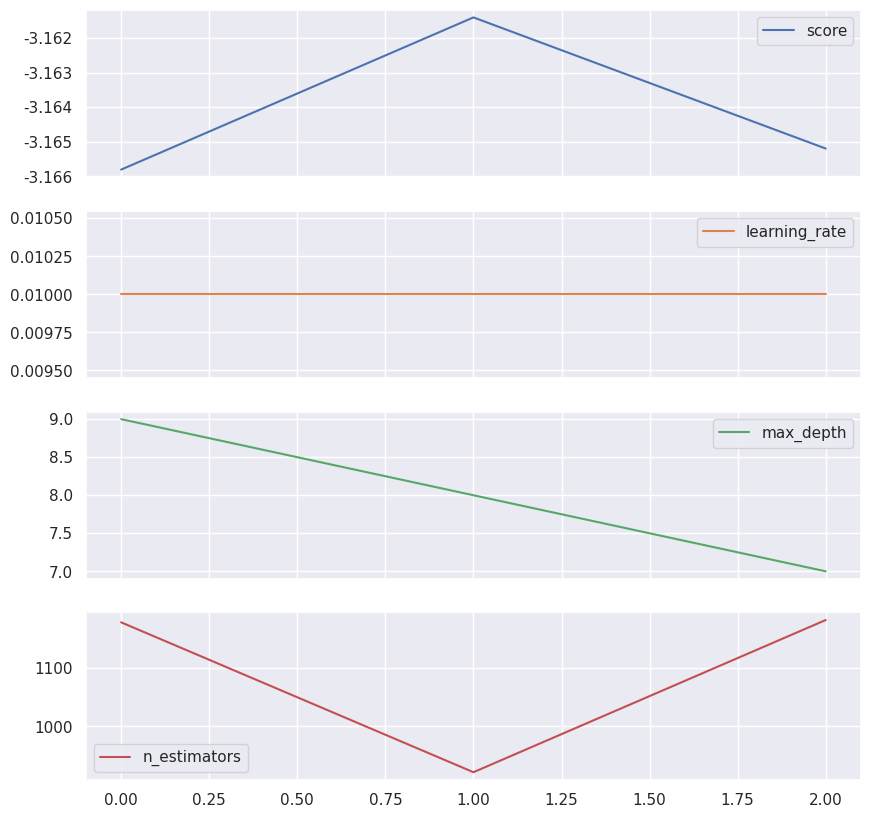

In [ ]:
rs_results_df=pd.DataFrame(np.transpose([rs1.cv_results_['mean_test_score'],
                                         rs1.cv_results_['param_learning_rate'].data,
                                         rs1.cv_results_['param_max_depth'].data,
                                         rs1.cv_results_['param_n_estimators'].data]),
                           columns=['score', 'learning_rate', 'max_depth', 'n_estimators'])
rs_results_df.plot(subplots=True,figsize=(10, 10))

In [ ]:
best_params['random_state'] = 42
best_params['verbose'] = -1

# best 모델 인스턴스 생성(정의)
best_mode = LGBMRegressor(**best_params)

In [ ]:
n_iter = 0
accuracy_lst = []

for train_index, valid_index in skf.split(train_features, train_target):
  n_iter += 1
  # 학습용, 검증용 데이터 구성
  train_x, valid_x = train_features.iloc[train_index], train_features.iloc[valid_index]
  train_y, valid_y = train_target.iloc[train_index], train_target.iloc[valid_index]

  # 학습
  model.fit(train_x, train_y)
  valid_pred = model.predict(valid_x) # 예측값

  # 평가
  rmse = mean_squared_error(valid_y, valid_pred, squared=False)
  rmse_lst.append(rmse)
  print(f'{n_iter} 번째 Stratified K-Fold RMSE: {rmse}')

# 최종 평가
print('-'*50)
print(f'교차 검증 RMSE: {np.mean(rmse_lst)}')

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=6.
  warnings.warn(


1 번째 Stratified K-Fold RMSE: 3.1708119113494386
2 번째 Stratified K-Fold RMSE: 3.1246687240279516
3 번째 Stratified K-Fold RMSE: 3.163598885443988
4 번째 Stratified K-Fold RMSE: 3.134387742786986
5 번째 Stratified K-Fold RMSE: 3.205449029582139
6 번째 Stratified K-Fold RMSE: 3.1764365553818883
--------------------------------------------------
교차 검증 RMSE: 3.1761336478670246


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 45432 (\N{HANGUL SYLLABLE NO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47732 (\N{HANGUL SYLLABLE MYEON}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 53468 (\N{HANGUL SYLLABLE TAE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages

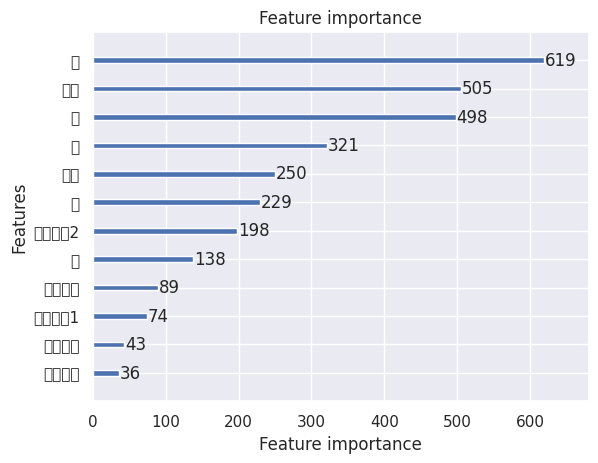

In [ ]:
plot_importance(model)
plt.show()

## Catboost

### model 1

In [ ]:
from catboost import CatBoostRegressor

In [ ]:
hp = {
    "random_state" : 42,
    "verbose" : 0 # 부스팅 단계 출력 안보이게 하기
}
model = CatBoostRegressor(**hp)
n_iter = 0
accuracy_lst = []

for train_index, valid_index in skf.split(train_features, train_target):
  n_iter += 1
  # 학습용, 검증용 데이터 구성
  train_x, valid_x = train_features.iloc[train_index], train_features.iloc[valid_index]
  train_y, valid_y = train_target.iloc[train_index], train_target.iloc[valid_index]

  # 학습
  model.fit(train_x, train_y)
  valid_pred = model.predict(valid_x) # 예측값

  # 평가
  rmse = mean_squared_error(valid_y, valid_pred, squared=False)
  rmse_lst.append(rmse)
  print(f'{n_iter} 번째 Stratified K-Fold RMSE: {rmse}')

# 최종 평가
print('-'*50)
print(f'교차 검증 RMSE: {np.mean(rmse_lst)}')

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=6.
  warnings.warn(


1 번째 Stratified K-Fold RMSE: 3.175908631552551
2 번째 Stratified K-Fold RMSE: 3.148985683933967
3 번째 Stratified K-Fold RMSE: 3.1781195462802847
4 번째 Stratified K-Fold RMSE: 3.163500522625371
5 번째 Stratified K-Fold RMSE: 3.22562249394781
6 번째 Stratified K-Fold RMSE: 3.1998367677117106
--------------------------------------------------
교차 검증 RMSE: 3.1775991378190898


### model 2

In [ ]:
hp = {
    "random_state" : 42,
    "verbose": 0, # 로그
}
model = CatBoostRegressor(**hp)

In [ ]:
n_iter=3 # 몇번 hp조합을 찾을 것인가?
scoring = 'neg_root_mean_squared_error' # 어떤 평가지표를 사용할 것인가?
hp={
    "max_depth" : np.linspace(5,12,8,dtype = int), # 깊이
    "n_estimators" : np.linspace(100,500,100, dtype = int), # 부스팅 단계수
    "learning_rate" : np.logspace(-3, -1, 3)
}

# HPO 인스턴스 생성
rs1=RandomizedSearchCV(model, hp, scoring=scoring, n_iter=n_iter, n_jobs=-1, cv=skf, verbose=False)
# 학습 (best hp 조합 찾기)
rs1.fit(train_x, train_y)

# 학습 결과 (best hp 조합일 때,)
rs1.best_score_

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=6.
  warnings.warn(


-3.1586995113218372

In [ ]:
best_params = rs1.best_params_
best_params

{'n_estimators': 253, 'max_depth': 5, 'learning_rate': 0.1}

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object)

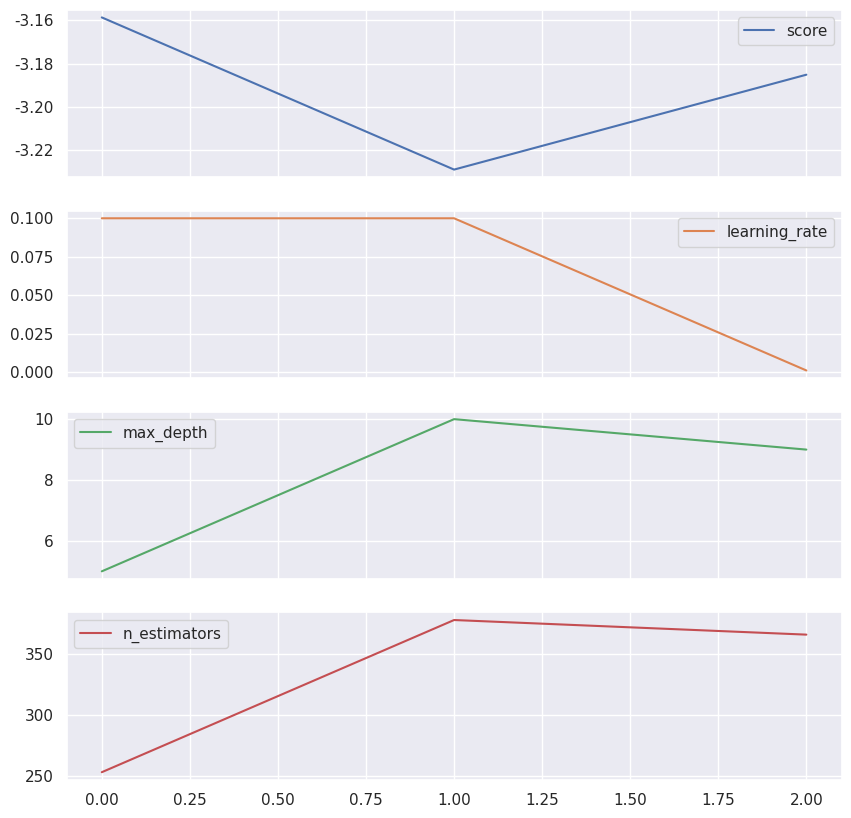

In [ ]:
rs_results_df=pd.DataFrame(np.transpose([rs1.cv_results_['mean_test_score'],
                                         rs1.cv_results_['param_learning_rate'].data,
                                         rs1.cv_results_['param_max_depth'].data,
                                         rs1.cv_results_['param_n_estimators'].data]),
                           columns=['score', 'learning_rate', 'max_depth', 'n_estimators'])
rs_results_df.plot(subplots=True,figsize=(10, 10))

In [ ]:
best_params['random_state'] = 42
best_params['verbose'] = 0

# best 모델 인스턴스 생성(정의)
best_mode = CatBoostRegressor(**best_params)

In [ ]:
n_iter = 0
accuracy_lst = []

for train_index, valid_index in skf.split(train_features, train_target):
  n_iter += 1
  # 학습용, 검증용 데이터 구성
  train_x, valid_x = train_features.iloc[train_index], train_features.iloc[valid_index]
  train_y, valid_y = train_target.iloc[train_index], train_target.iloc[valid_index]

  # 학습
  model.fit(train_x, train_y)
  valid_pred = model.predict(valid_x) # 예측값

  # 평가
  rmse = mean_squared_error(valid_y, valid_pred, squared=False)
  rmse_lst.append(rmse)
  print(f'{n_iter} 번째 Stratified K-Fold RMSE: {rmse}')

# 최종 평가
print('-'*50)
print(f'교차 검증 RMSE: {np.mean(rmse_lst)}')

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=6.
  warnings.warn(


1 번째 Stratified K-Fold RMSE: 3.175908631552551
2 번째 Stratified K-Fold RMSE: 3.148985683933967
3 번째 Stratified K-Fold RMSE: 3.1781195462802847
4 번째 Stratified K-Fold RMSE: 3.163500522625371
5 번째 Stratified K-Fold RMSE: 3.22562249394781
6 번째 Stratified K-Fold RMSE: 3.1998367677117106
--------------------------------------------------
교차 검증 RMSE: 3.1784784317903285


Text(0.5, 1.0, 'Feature Importance')

/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 49884 (\N{HANGUL SYLLABLE SI}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 53468 (\N{HANGUL SYLLABLE TAE}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 45432 (\N{HANGUL SYLLABLE NO}) missing from current font.
  func(*args,

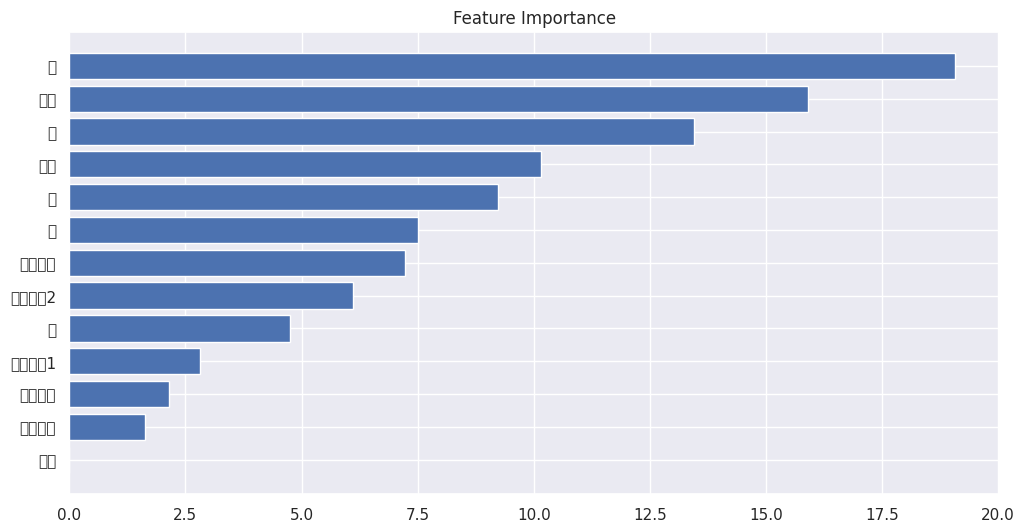

In [ ]:
feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)

fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
# plt.yticks(range(len(sorted_idx)), np.array(range(len(train_x)))[sorted_idx])
# 변수명이 있다면, 아래와 같이...
plt.yticks(range(len(sorted_idx)), np.array(train_x.columns)[sorted_idx])
plt.title('Feature Importance')

## RandomForest

### model 1

In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
hp = {
    "random_state": 42,
    "verbose": 0  # 부스팅 단계 출력 안보이게 하기
}
model = RandomForestRegressor(**hp)  # RandomForestRegressor로 모델 변경
n_iter = 0
rmse_lst = []

for train_index, valid_index in skf.split(train_features, train_target):
    n_iter += 1
    # 학습용, 검증용 데이터 구성
    train_x, valid_x = train_features.iloc[train_index], train_features.iloc[valid_index]
    train_y, valid_y = train_target.iloc[train_index], train_target.iloc[valid_index]

    # 학습
    model.fit(train_x, train_y)
    valid_pred = model.predict(valid_x)  # 예측값

    # 평가
    rmse = mean_squared_error(valid_y, valid_pred, squared=False)
    rmse_lst.append(rmse)
    print(f'{n_iter} 번째 Stratified K-Fold RMSE: {rmse}')

# 최종 평가
print('-' * 50)
print(f'교차 검증 RMSE: {np.mean(rmse_lst)}')

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=6.
  warnings.warn(


1 번째 Stratified K-Fold RMSE: 3.2909646818408547
2 번째 Stratified K-Fold RMSE: 3.249468547198853
3 번째 Stratified K-Fold RMSE: 3.2727318325949035
4 번째 Stratified K-Fold RMSE: 3.2628380384545075
5 번째 Stratified K-Fold RMSE: 3.3267733184671435
6 번째 Stratified K-Fold RMSE: 3.2962981956641353
--------------------------------------------------
교차 검증 RMSE: 3.2831791023700667


### model 2

In [ ]:
hp = {
    "random_state" : 42,
    "verbose": 0, # 로그
}
model = RandomForestRegressor(**hp)

In [ ]:
n_iter=5 # 몇번 hp조합을 찾을 것인가?
scoring = 'neg_root_mean_squared_error' # 어떤 평가지표를 사용할 것인가?
hp={
    "max_depth" : np.linspace(5,12,8,dtype = int), # 깊이
    "n_estimators" : np.linspace(100,500,100, dtype = int), # 부스팅 단계수
}

# HPO 인스턴스 생성
rs1 = RandomizedSearchCV(RandomForestRegressor(), hp, scoring=scoring, n_iter=n_iter, n_jobs=-1, cv=skf, verbose=3)
# 학습 (best hp 조합 찾기)
rs1.fit(train_x, train_y)

# 학습 결과 (best hp 조합일 때,)
rs1.best_score_

Fitting 6 folds for each of 5 candidates, totalling 30 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=6.
  warnings.warn(


-3.160558223316796

In [ ]:
best_params = rs1.best_params_
best_params

{'n_estimators': 156, 'max_depth': 7}

array([<Axes: >, <Axes: >, <Axes: >], dtype=object)

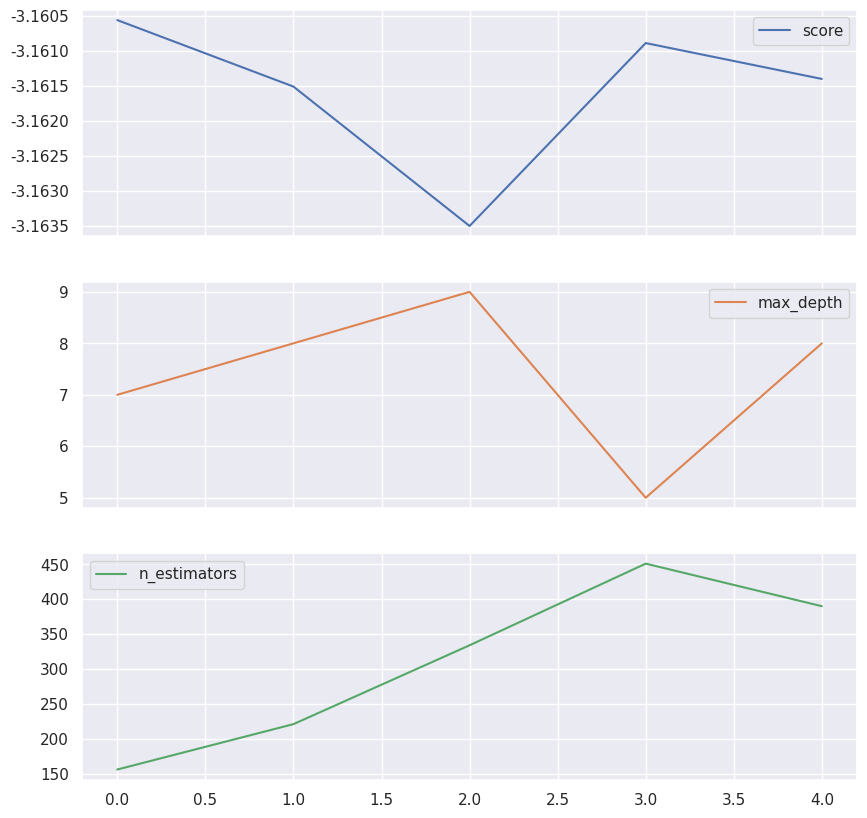

In [ ]:
rs_results_df=pd.DataFrame(np.transpose([rs1.cv_results_['mean_test_score'],
                                         rs1.cv_results_['param_max_depth'].data,
                                         rs1.cv_results_['param_n_estimators'].data]),
                           columns=['score', 'max_depth', 'n_estimators'])
rs_results_df.plot(subplots=True,figsize=(10, 10))

In [ ]:
best_params['random_state'] = 42
best_params['verbose'] = 0

# best 모델 인스턴스 생성(정의)
best_model = RandomForestRegressor(**best_params)

In [ ]:
n_iter = 0
accuracy_lst = []

for train_index, valid_index in skf.split(train_features, train_target):
  n_iter += 1
  # 학습용, 검증용 데이터 구성
  train_x, valid_x = train_features.iloc[train_index], train_features.iloc[valid_index]
  train_y, valid_y = train_target.iloc[train_index], train_target.iloc[valid_index]

  # 학습
  model.fit(train_x, train_y)
  valid_pred = model.predict(valid_x) # 예측값

  # 평가
  rmse = mean_squared_error(valid_y, valid_pred, squared=False)
  rmse_lst.append(rmse)
  print(f'{n_iter} 번째 Stratified K-Fold RMSE: {rmse}')

# 최종 평가
print('-'*50)
print(f'교차 검증 RMSE: {np.mean(rmse_lst)}')

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=6.
  warnings.warn(


1 번째 Stratified K-Fold RMSE: 3.2909646818408547
2 번째 Stratified K-Fold RMSE: 3.249468547198853
3 번째 Stratified K-Fold RMSE: 3.2727318325949035
4 번째 Stratified K-Fold RMSE: 3.2628380384545075
5 번째 Stratified K-Fold RMSE: 3.3267733184671435
6 번째 Stratified K-Fold RMSE: 3.2962981956641353
--------------------------------------------------
교차 검증 RMSE: 3.2831791023700667


## train_y, pred RMSE

In [ ]:
model

RandomForestRegressor(random_state=42)

In [ ]:
pred = model.predict(train_x)

# RMSE 계산
rmse = np.sqrt(mean_squared_error(train_y, pred))
print(f'RMSE: {rmse}')

RMSE: 1.2420760791636143


In [ ]:
pred_df = pd.DataFrame(pred, columns=['ECLO'])

# 학습 평가

## 산포도

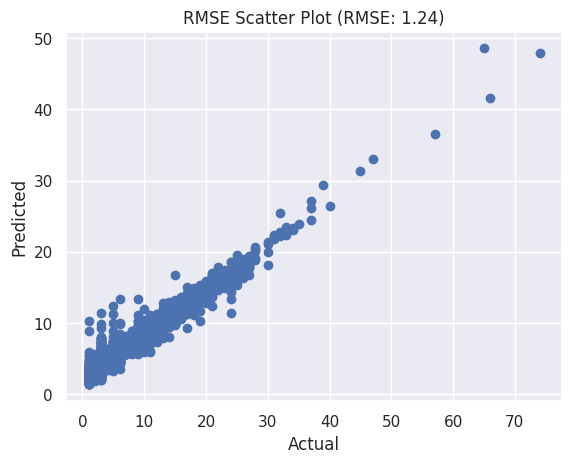

In [ ]:
import matplotlib.pyplot as plt

# train_y와 pred의 RMSE를 계산
rmse = np.sqrt(mean_squared_error(train_y, pred))

# 산포도 그래프 생성
plt.scatter(train_y, pred)

# 그래프에 제목과 x축, y축 레이블 추가
plt.title(f'RMSE Scatter Plot (RMSE: {rmse:.2f})')
plt.xlabel('Actual')
plt.ylabel('Predicted')

# 그래프 표시
plt.show()

## **Submission 양식 확인**

sample_submission.csv 화일 데이터(sample_submission)를 그대로 복사한 후,
양식의 'ECLO' 컬럼에 test_x에 대한 ECLO(y) 예측값을 입력합니다

In [ ]:
prediction =  model.predict(test_features)

In [ ]:
baseline_submission = sample_submission.copy()
baseline_submission['ECLO'] = prediction
baseline_submission

,ID,ECLO
0,ACCIDENT_39609,5.11
1,ACCIDENT_39610,4.19
2,ACCIDENT_39611,7.70
3,ACCIDENT_39612,8.19
4,ACCIDENT_39613,5.78
...,...,...
10958,ACCIDENT_50567,7.55
10959,ACCIDENT_50568,4.71
10960,ACCIDENT_50569,5.38
10961,ACCIDENT_50570,5.74


## **답안지 저장 및 제출하기**

In [ ]:
baseline_submission.to_csv('Hyul_submit.csv', index=False)

# autogluon : TabularDataset

## model 1

In [ ]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [ ]:
train_df.columns

Index(['ID', '사고일시', '요일', '기상상태', '시군구', '도로형태', '노면상태', '사고유형',
       '사고유형 - 세부분류', '법규위반', '가해운전자 차종', '가해운전자 성별', '가해운전자 연령', '가해운전자 상해정도',
       '피해운전자 차종', '피해운전자 성별', '피해운전자 연령', '피해운전자 상해정도', '사망자수', '중상자수',
       '경상자수', '부상자수', 'ECLO'],
      dtype='object')

In [ ]:
test_df.columns

Index(['ID', '사고일시', '요일', '기상상태', '시군구', '도로형태', '노면상태', '사고유형'], dtype='object')

In [ ]:
# autogluon 학습을 위한 데이터 형태로 변환
train = TabularDataset(train_df.drop(['ID','사고유형 - 세부분류', '법규위반', '가해운전자 차종', '가해운전자 성별', '가해운전자 연령', '가해운전자 상해정도',
       '피해운전자 차종', '피해운전자 성별', '피해운전자 연령', '피해운전자 상해정도', '사망자수', '중상자수',
       '경상자수', '부상자수'], axis=1))
test = TabularDataset(test_df.drop(['ID'], axis=1))

In [ ]:
excluded_models = ['Cat', 'cat','CAT','cAt','caT', 'CAt']

In [ ]:
predictor = TabularPredictor(label='ECLO', eval_metric='rmse',).fit(train ,excluded_model_types = excluded_models)

No path specified. Models will be saved in: "AutogluonModels/ag-20231121_103651/"
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/ag-20231121_103651/"
AutoGluon Version:  0.8.2
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Wed Aug 30 11:19:59 UTC 2023
Disk Space Avail:   80.03 GB / 115.66 GB (69.2%)
Train Data Rows:    39609
Train Data Columns: 7
Label Column: ECLO
Preprocessing data ...
AutoGluon infers your prediction problem is: 'multiclass' (because dtype of label-column == int, but few unique label-values observed).
	First 10 (of 46) unique label values:  [5, 3, 6, 18, 9, 8, 15, 2, 1, 7]
	If 'multiclass' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Fraction of data from classes with at least 10 examples that will be kept for training models: 0.99883

In [ ]:
# 각각의 모델의 훈련 성능을 평가할 수 있음
ld_board = predictor.leaderboard(train, silent=True)
ld_board

,model,score_test,score_val,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,RandomForestEntr,-1.506347,-3.633258,10.232569,0.307091,27.543921,10.232569,0.307091,27.543921,1,True,6
1,RandomForestGini,-1.512018,-3.664689,12.796964,0.604591,22.437366,12.796964,0.604591,22.437366,1,True,5
2,ExtraTreesEntr,-1.586021,-3.636451,9.026081,0.296161,21.879056,9.026081,0.296161,21.879056,1,True,8
3,ExtraTreesGini,-1.589377,-3.647443,10.784469,0.245041,13.053675,10.784469,0.245041,13.053675,1,True,7
4,KNeighborsDist,-2.320645,-3.885212,0.261686,0.029125,0.111066,0.261686,0.029125,0.111066,1,True,2
5,LightGBMLarge,-2.739675,-3.818280,46.453337,3.161512,55.750314,46.453337,3.161512,55.750314,1,True,11
6,WeightedEnsemble_L2,-3.481600,-3.417213,1.226366,0.141098,60.482733,0.054916,0.001125,1.348011,2,True,12
7,LightGBM,-3.489003,-3.690596,5.015699,0.329832,22.666812,5.015699,0.329832,22.666812,1,True,4
8,KNeighborsUnif,-3.599731,-3.623217,0.284438,0.031973,0.104437,0.284438,0.031973,0.104437,1,True,1
9,LightGBMXT,-3.633084,-3.442482,1.748487,0.116613,24.432415,1.748487,0.116613,24.432415,1,True,3


In [ ]:
# 예측하기
pred_y = predictor.predict(test)

In [ ]:
# 제출 파일 생성
submission = pd.DataFrame()

submission['ID'] = test_df['ID']
submission['ECLO'] = pred_y

In [ ]:
submission.to_csv('Hyul_submit.csv', index=False)

# autogluon : TimeSeriesDataFrame

## model 1

In [ ]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
train_c = train_df.copy()
test_c = test_df.copy()

In [ ]:
train_c['timestamp'] = pd.to_datetime(train_c['사고일시']).dt.date
test_c['timestamp'] = pd.to_datetime(test_c['사고일시']).dt.date

In [ ]:
train_c['item_id'] = train_c.ID.str[0:8]
test_c['item_id'] = test_c.ID.str[0:8]
test_c['ECLO'] = 0

In [ ]:
# autogluon 학습을 위한 데이터 형태로 변환
train = train_c.drop(['사고유형 - 세부분류', '법규위반', '가해운전자 차종', '가해운전자 성별', '가해운전자 연령', '가해운전자 상해정도',
       '피해운전자 차종', '피해운전자 성별', '피해운전자 연령', '피해운전자 상해정도', '사망자수', '중상자수',
       '경상자수', '부상자수', '사고일시', '기상상태', '시군구', 'ID', '도로형태', '노면상태', '사고유형'], axis=1)
test = test_c.drop(['ID', '사고일시', '기상상태', '시군구', '도로형태', '노면상태', '사고유형'], axis=1)

In [ ]:
train1 = train.groupby(['timestamp', 'item_id']).agg({'ECLO': 'mean'}).reset_index()
test1 = test.groupby(['timestamp', 'item_id']).agg({'ECLO': 'mean'}).reset_index()

In [ ]:
excluded_models = ['DeepAR']

In [ ]:
train1['ECLO'] = np.log(train1['ECLO'])

In [ ]:
train1

,timestamp,item_id,ECLO
0,2019-01-01,ACCIDENT,1.660731
1,2019-01-02,ACCIDENT,1.455287
2,2019-01-03,ACCIDENT,1.457246
3,2019-01-04,ACCIDENT,1.559738
4,2019-01-05,ACCIDENT,1.538564
...,...,...,...
1091,2021-12-27,ACCIDENT,1.431318
1092,2021-12-28,ACCIDENT,1.304949
1093,2021-12-29,ACCIDENT,1.575536
1094,2021-12-30,ACCIDENT,1.351927


In [ ]:
data = TimeSeriesDataFrame(train1)
predictor = TimeSeriesPredictor(
    prediction_length=365,
    target="ECLO",
    eval_metric="RMSE",
    ignore_time_index=True
)
# seed 고정
predictor.fit(data, random_seed=42,excluded_model_types = excluded_models,)

================ TimeSeriesPredictor ================
TimeSeriesPredictor.fit() called
Fitting with arguments:
{'enable_ensemble': True,
 'evaluation_metric': 'RMSE',
 'excluded_model_types': ['DeepAR'],
 'hyperparameter_tune_kwargs': None,
 'hyperparameters': 'default',
 'num_val_windows': 1,
 'prediction_length': 365,
 'random_seed': 42,
 'target': 'ECLO',
 'time_limit': None,
 'verbosity': 2}
Provided training data set with 1096 rows, 1 items (item = single time series). Average time series length is 1096.0. Data frequency is 'S'.
INFO:lightning_fabric.utilities.seed:Global seed set to 42
AutoGluon will save models to AutogluonModels/ag-20231122_105247/
AutoGluon will gauge predictive performance using evaluation metric: 'RMSE'
	This metric's sign has been flipped to adhere to being 'higher is better'. The reported score can be multiplied by -1 to get the metric value.

Provided dataset contains following columns:
	target:           'ECLO'

Starting training. Start time is 2023-11-2

In [64]:
# 각각의 모델의 훈련 성능을 평가할 수 있음
ld_board = predictor.leaderboard(data, silent=True)
ld_board

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <cell line: 2>:2                                                                              │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'predictor' is not defined

In [ ]:
predictor.refit_full()

Refitting models via `refit_full` using all of the data (combined train and validation)...
	Models trained in this way will have the suffix '_FULL' and have NaN validation score.
	This process is not bound by time_limit, but should take less time than the original `fit` call.
Fitting model: Naive_FULL | Skipping fit via cloning parent ...
Fitting model: SeasonalNaive_FULL | Skipping fit via cloning parent ...
Fitting model: Theta_FULL | Skipping fit via cloning parent ...
Fitting model: AutoETS_FULL | Skipping fit via cloning parent ...
Fitting model: RecursiveTabular_FULL
	4.56    s     = Training runtime
Fitting model: WeightedEnsemble_FULL | Skipping fit via cloning parent ...
Refit complete. Models trained: ['Naive_FULL', 'SeasonalNaive_FULL', 'Theta_FULL', 'AutoETS_FULL', 'RecursiveTabular_FULL', 'WeightedEnsemble_FULL']
Total runtime: 4.61 s
Updated best model to 'WeightedEnsemble_FULL' (Previously 'WeightedEnsemble'). AutoGluon will default to using 'WeightedEnsemble_FULL' for p

{'Naive': 'Naive_FULL',
 'SeasonalNaive': 'SeasonalNaive_FULL',
 'Theta': 'Theta_FULL',
 'AutoETS': 'AutoETS_FULL',
 'RecursiveTabular': 'RecursiveTabular_FULL',
 'WeightedEnsemble': 'WeightedEnsemble_FULL'}

In [ ]:
# seed 고정
pred = predictor.predict(data, random_seed=42, )

INFO:lightning_fabric.utilities.seed:Global seed set to 42
Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble_FULL


In [ ]:
test1['ECLO'] = pred.reset_index()['mean']

In [ ]:
test_c['timestamp'] = pd.to_datetime(test_c['timestamp'])
test1['timestamp'] = pd.to_datetime(test1['timestamp'])
test_c = test_c.drop(columns =['ECLO'])

In [ ]:
test1['ECLO'] = np.exp(test1['ECLO'])

In [ ]:
test1

,timestamp,item_id,ECLO
0,2022-01-01,ACCIDENT,4.554452
1,2022-01-02,ACCIDENT,4.558180
2,2022-01-03,ACCIDENT,4.551305
3,2022-01-04,ACCIDENT,4.553330
4,2022-01-05,ACCIDENT,4.552395
...,...,...,...
360,2022-12-27,ACCIDENT,4.724676
361,2022-12-28,ACCIDENT,4.725925
362,2022-12-29,ACCIDENT,4.719973
363,2022-12-30,ACCIDENT,4.720735


In [ ]:
merged_df = pd.merge(test_c, test1[['timestamp', 'ECLO']], on='timestamp', how='left')
submission = merged_df[['ID', 'ECLO']]

In [ ]:
submission.to_csv('./TimeSeries_submission.csv', index=False)